In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip /content/drive/MyDrive/lfw.zip


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
path = r'C:\Users\Manu\IdeaProjects\Python\PR\github\Pattern-Recognition\HW3\lfw\lfw'
# path = '/content/lfw'

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform, ), batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
# if torch.backends.cuda.():
#     device = torch.device("mps")
# else:
#     print ("MPS device not found.")

# torch.cuda.get_device_name()

# device = torch.device("NVIDIA GeForce RTX 3050 Ti Laptop GPU")

device = torch.device("cuda")  # using GPU


torch.Size([250, 250, 3])


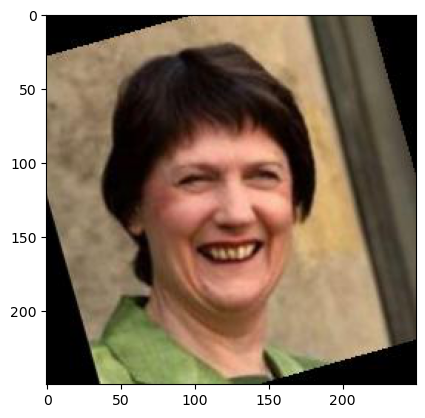

In [6]:
for x, y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

Generated

Differences between Autoencoders and VAEs:
Applications:

AutoEncoders:
Data compression and dimensionality reduction.
Anomaly detection by identifying data points not well-reconstructed by the model.
Feature learning for other tasks like classification or regression.
VAEs:
Image and text generation based on learned latent representations.
Style transfer between images.
Generating diverse data points within a learned data manifold.
Architecture:

AutoEncoders:
Simple encoder-decoder architecture with symmetric connections.
Focuses on reconstructing the input data as accurately as possible.
VAEs:
Encoder outputs parameters of a probability distribution (e.g., Gaussian) in the latent space.
Decoder samples from the latent distribution to generate new data points.
Additional regularization term in the loss function encourages latent space to be smooth and interpretable.

Loss Function:

AutoEncoders:
Typically uses reconstruction error metrics like Mean Squared Error (MSE) or cross-entropy.
VAEs:
Combines reconstruction error with a Kullback-Leibler (KL) divergence term.
KL divergence penalizes deviations of the latent distribution from a prior distribution (often a standard normal). This encourages efficient use of the latent space and prevents overfitting.
Summary:

Autoencoders prioritize faithful reconstruction, while VAEs focus on learning a flexible and generative latent space.
VAEs have additional complexity in the architecture and loss function, but offer more powerful generation and exploration capabilities.

**Differences between Autoencoders and VAEs:**
**Applications:**

    AutoEncoders:
    - Data compression and dimensionality reduction.
    - Anomaly detection through identifying data points that are not well reconstructed by the model.
    - Feature Learning for tasks like classification or regression.

    VAEs:
    - Latent representations are learned.
    - Image and text generation.

**Architecture:**

    AutoEncoders:
    - Encoder-decoder architecture with symmetric connections.
    - Tries to rebuild the input data as correct as possible.

    VAEs:
    - Encoder outputs the parameters of a probability distribution (e.g., Gaussian) in the latent space.
    - The decoder takes samples from the latent distribution to create new data points.
    - An extra regularization term in the loss function pushes latent space to be smooth.

**Loss Function:**

    AutoEncoders:
        - It most often uses reconstruction error metrics such as Mean Squared Error (MSE) or cross-entropy.

    VAEs:
        - This error term is combined with a Kullback-Leibler (KL) divergence term.
        - KL divergence punishes departures of the latent distribution from a prior (usually normal). This leads to effective use of the latent space and avoids overfitting.

While autoencoders emphasize reconstruction, VAEs are designed to learn a flexible and generative latent space.
VAEs are more complex in their architecture and loss function, but they have stronger generation and exploration capabilities.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [7]:
class VAE(nn.Module):

    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder layers

        self.encoder_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(64)
        self.encoder_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.encoder_bn2 = nn.BatchNorm2d(128)
        self.encoder_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(256)

        self.flatten = nn.Flatten()
        self.mean = nn.Linear(256 * 31 * 31, latent_dim)
        self.log_var = nn.Linear(256 * 31 * 31, latent_dim)
        self.fdecoder = nn.Linear(latent_dim, 256 * 31 * 31)
        self.reshape = lambda x: x.view(-1, *(256, 31, 31))

        # Decoder layers

        self.decoder_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2)
        self.decoder_bn1 = nn.BatchNorm2d(128)
        self.decoder_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(64)
        self.decoder_conv3 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn3 = nn.BatchNorm2d(3)

    def encoder(self, x):
        x = nn.functional.relu(self.encoder_conv1(x))
        x = nn.functional.relu(self.encoder_conv2(x))
        x = nn.functional.relu(self.encoder_conv3(x))

        x = self.flatten(x)
        mu = self.mean(x)
        logvar = self.log_var(x)

        return mu, logvar

    def decoder(self, x):
        x = self.fdecoder(x)
        x = self.reshape(x)
        x = nn.functional.relu(self.decoder_conv1(x))
        x = nn.functional.relu(self.decoder_conv2(x))
        x = torch.sigmoid(self.decoder_conv3(x))
        return x

    def forward(self, x):
        mu_f, logvar_f = self.encoder(x)

        std_f = torch.exp(0.5 * logvar_f)
        z = torch.randn_like(mu_f, device=device) * std_f + mu_f

        x = self.decoder(z)
        return x, mu_f, logvar_f

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

**Encoder Output and Latent Space Manipulation:**

**Encoder Function:** The VAE uses a three-layer convolutional encoder with ReLU activation and batch normalization. This gradually extracts latent features from the input image.

**Latent Distribution Parameters:** The flattened feature map is next passed into two fully-connected layers. The first outputs the mean (μ) of the latent distribution, and the second outputs log variance (log σ²). These parameters define a 505-dimensional Gaussian latent space that captures the essence of an image.

**Generating New Samples:** To produce brand new pictures, we randomly select a noise vector (z) from a standard normal distribution of the same dimension as μ and log σ². We then add this noise by standard deviation (√σ²) to μ to obtain a new latent vector. The new vector brings together randomness with the learned structure of the input data.

**Model Forward Pass and Verification:**

In a forward pass, an image is taken from the dataset, encoded by the encoder in latent vector form and then decoded back into an image.

**Output Shapes:**
    Reconstructed image: Shape same as input image ([1, 3, 250, 250]).
    Mean and log variance of the latent distribution: Each has the expected dimension [1, 50].
    Shape Verification: This output verifies the model. The shape of the reconstructed image reflects batch processing, and the sizes of mean and log variance match the dimension in latent space.

So this VAE condenses images onto a 50-dimensional latent space. Through the injection of noise into points within this space, we create new images that maintain aesthetic attributes derived from the training data. The produced output verifies that the model is working properly, as it shows image processing, formation of latent representations and a successful reconstruction.


In [8]:
model = VAE(50).to(device)
# Pass the image through the model
image, _ = next(iter(dataloader))
image = image[0].to(device)
print("Image shape", image.shape)

output, _, _ = model.forward(image.unsqueeze(0))
print("Forward Output Shape:", output.shape)

# Get the encoder and decoder outputs
mu, logvar = model.encoder(image.unsqueeze(0))
print("Size of mean (encoder output 1):", mu.size())
print("Size of log_var (encoder output 2):", logvar.size())
z = torch.randn_like(mu) * torch.exp(0.5 * logvar) + mu
reconstruction = model.decoder(z)
print("Size of reconstructed image (decoder output):", reconstruction.size())


Image shape torch.Size([3, 250, 250])
Forward Output Shape: torch.Size([1, 3, 250, 250])
Size of mean (encoder output 1): torch.Size([1, 50])
Size of log_var (encoder output 2): torch.Size([1, 50])
Size of reconstructed image (decoder output): torch.Size([1, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [9]:
# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print("Total Parameters:", total_params)

Total Parameters: 37891181


* create an optimizer for training

In [10]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

I’ve tried out different parameters for variational autoencoders, tested their performance and tweaking settings to get the best results. I’ve included few of the models below

    
    No.of Epochs - 50
    Latent Space - 128
    Learning rate - 0.001
    Final Activation function - sigmoid
        
    Epoch [1/50], Loss: 2918.1018753420326
    Epoch [2/50], Loss: 1683.6673480784837
    Epoch [3/50], Loss: 1449.3698942764945
    Epoch [4/50], Loss: 1350.9215344415195
    Epoch [5/50], Loss: 1290.7906830276268
    Epoch [6/50], Loss: 1250.7521263527985
    Epoch [7/50], Loss: 1212.3631621282457
    Epoch [8/50], Loss: 1180.8738842655496
    Epoch [9/50], Loss: 1142.144532724279
    Epoch [10/50], Loss: 1112.277371171592
    Epoch [11/50], Loss: 1079.957167768248
    Epoch [12/50], Loss: 1053.3290051446445
    Epoch [13/50], Loss: 1024.3786289380944
    Epoch [14/50], Loss: 999.2967489491339
    Epoch [15/50], Loss: 975.6302030259285
    Epoch [16/50], Loss: 954.7122646460787
    Epoch [17/50], Loss: 937.7358131592977
    Epoch [18/50], Loss: 912.5716767979129
    Epoch [19/50], Loss: 895.3577538826615
    Epoch [20/50], Loss: 880.4913054387927
    Epoch [21/50], Loss: 866.8985999655608
    Epoch [22/50], Loss: 851.1862582146833
    Epoch [23/50], Loss: 836.2488479982827
    Epoch [24/50], Loss: 829.2056069489263
    Epoch [25/50], Loss: 819.483140733507
    Epoch [26/50], Loss: 805.8754894606733
    Epoch [27/50], Loss: 795.7736160352034
    Epoch [28/50], Loss: 789.2121573185575
    Epoch [29/50], Loss: 780.8945343459861
    Epoch [30/50], Loss: 770.770707577323
    Epoch [31/50], Loss: 765.0805481251887
    Epoch [32/50], Loss: 757.6447181885945
    Epoch [33/50], Loss: 751.8990764525778
    Epoch [34/50], Loss: 746.5763738512417
    Epoch [35/50], Loss: 738.5271189224317
    Epoch [36/50], Loss: 733.5927305359771
    Epoch [37/50], Loss: 730.9804634425951
    Epoch [38/50], Loss: 724.9147356558537
    Epoch [39/50], Loss: 717.8668762796743
    Epoch [40/50], Loss: 714.6874535602072
    Epoch [41/50], Loss: 709.1427398534213
    Epoch [42/50], Loss: 706.6929381734507
    Epoch [43/50], Loss: 701.6593509987357
    Epoch [44/50], Loss: 696.4805871346147
    Epoch [45/50], Loss: 695.0472976758284
    Epoch [46/50], Loss: 690.2985254554933
    Epoch [47/50], Loss: 686.6617608554121
    Epoch [48/50], Loss: 685.0986889825351
    Epoch [49/50], Loss: 681.3590708562141
    Epoch [50/50], Loss: 676.8924763997396

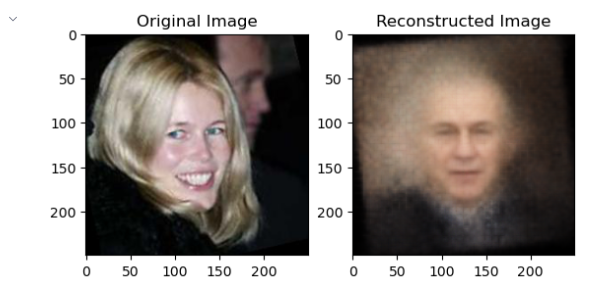


No.of Epochs - 30
Latent Space - 256
Learning rate - 0.001
Final Activation function - sigmoid
    
    Epoch [1/30], Loss: 2963.368998504491
    Epoch [2/30], Loss: 1787.066008489489
    Epoch [3/30], Loss: 1555.2776996409837
    Epoch [4/30], Loss: 1419.1386535939387
    Epoch [5/30], Loss: 1332.101461954163
    Epoch [6/30], Loss: 1262.174536663553
    Epoch [7/30], Loss: 1202.3921715188142
    Epoch [8/30], Loss: 1156.0218134341033
    Epoch [9/30], Loss: 1114.228177425366
    Epoch [10/30], Loss: 1073.7423849059765
    Epoch [11/30], Loss: 1034.5903458894738
    Epoch [12/30], Loss: 1013.4005295020946
    Epoch [13/30], Loss: 981.4134382902137
    Epoch [14/30], Loss: 955.6506141257171
    Epoch [15/30], Loss: 934.1886026133661
    Epoch [16/30], Loss: 920.2989577141361
    Epoch [17/30], Loss: 901.503105569001
    Epoch [18/30], Loss: 879.7431112833069
    Epoch [19/30], Loss: 866.998412348798
    Epoch [20/30], Loss: 858.1369079000132
    Epoch [21/30], Loss: 844.9259785085485
    Epoch [22/30], Loss: 831.712206117197
    Epoch [23/30], Loss: 821.6779275055669
    Epoch [24/30], Loss: 810.864445635662
    Epoch [25/30], Loss: 800.9913788578937
    Epoch [26/30], Loss: 795.884142447209
    Epoch [27/30], Loss: 786.9955186337089
    Epoch [28/30], Loss: 777.1366401709221
    Epoch [29/30], Loss: 771.4643963062821
    Epoch [30/30], Loss: 763.1865176878114

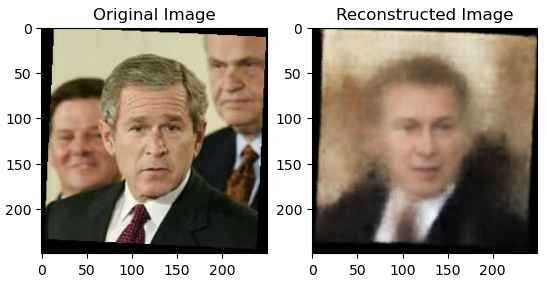


No.of Epochs - 30
Latent Space - 128
Learning rate - 0.001
Final Activation function - sigmoid
    
    
    Epoch [1/30], Loss: 2965.513420657835
    Epoch [2/30], Loss: 1665.077269918101
    Epoch [3/30], Loss: 1448.2720351656853
    Epoch [4/30], Loss: 1349.4021768616017
    Epoch [5/30], Loss: 1297.584059563236
    Epoch [6/30], Loss: 1253.8642861186595
    Epoch [7/30], Loss: 1219.4324809641078
    Epoch [8/30], Loss: 1184.4560813719525
    Epoch [9/30], Loss: 1157.6167996171591
    Epoch [10/30], Loss: 1123.7026939207806
    Epoch [11/30], Loss: 1092.0726947876567
    Epoch [12/30], Loss: 1061.8719615106997
    Epoch [13/30], Loss: 1037.5096714185631
    Epoch [14/30], Loss: 1011.1054920436104
    Epoch [15/30], Loss: 988.0720941663365
    Epoch [16/30], Loss: 965.737504452323
    Epoch [17/30], Loss: 942.3606154584654
    Epoch [18/30], Loss: 919.9011361679593
    Epoch [19/30], Loss: 900.5112889976317
    Epoch [20/30], Loss: 884.6010286635246
    Epoch [21/30], Loss: 870.1726318949087
    Epoch [22/30], Loss: 857.1178988396833
    Epoch [23/30], Loss: 845.5442046382001
    Epoch [24/30], Loss: 831.4594934435859
    Epoch [25/30], Loss: 818.631704579229
    Epoch [26/30], Loss: 810.9911173207748
    Epoch [27/30], Loss: 804.9172997221278
    Epoch [28/30], Loss: 793.1945214018153
    Epoch [29/30], Loss: 782.9622630243716
    Epoch [30/30], Loss: 771.043383464721

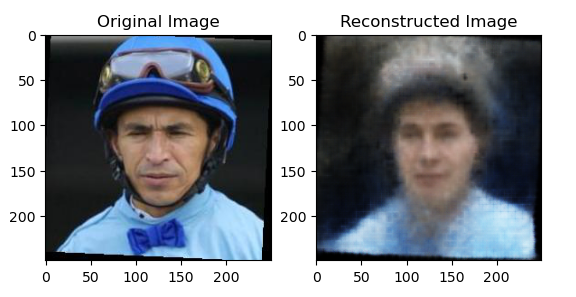



No.of Epochs - 30
Latent Space - 64
Learning rate - 0.001
Final Activation function - sigmoid

    
    Epoch [1/30], Loss: 3132.360495452144
    Epoch [2/30], Loss: 1796.2430797337333
    Epoch [3/30], Loss: 1618.552612894399
    Epoch [4/30], Loss: 1558.2566543063103
    Epoch [5/30], Loss: 1511.829518193784
    Epoch [6/30], Loss: 1478.5249014591825
    Epoch [7/30], Loss: 1445.1320043001774
    Epoch [8/30], Loss: 1414.5279113474676
    Epoch [9/30], Loss: 1386.740454927159
    Epoch [10/30], Loss: 1355.3225215598582
    Epoch [11/30], Loss: 1326.3682000349108
    Epoch [12/30], Loss: 1299.9488947034458
    Epoch [13/30], Loss: 1273.0406107879492
    Epoch [14/30], Loss: 1245.7346471519286
    Epoch [15/30], Loss: 1219.4388970269097
    Epoch [16/30], Loss: 1198.5356754911118
    Epoch [17/30], Loss: 1170.0552113113772
    Epoch [18/30], Loss: 1146.1158304260548
    Epoch [19/30], Loss: 1126.8257393215013
    Epoch [20/30], Loss: 1103.1988111118187
    Epoch [21/30], Loss: 1086.353363626821
    Epoch [22/30], Loss: 1065.4437649491904
    Epoch [23/30], Loss: 1051.592896244952
    Epoch [24/30], Loss: 1031.5297823551196
    Epoch [25/30], Loss: 1016.8128844919988
    Epoch [26/30], Loss: 1003.6314201907835
    Epoch [27/30], Loss: 986.9897537600015
    Epoch [28/30], Loss: 978.0320707311953
    Epoch [29/30], Loss: 962.9197057456786
    Epoch [30/30], Loss: 953.6729339747037

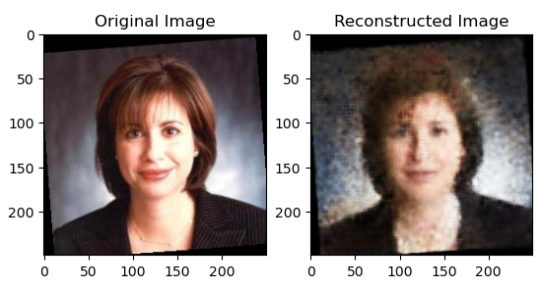



No.of Epochs - 100
Latent Space - 64
Learning rate - 0.001
Final Activation function - sigmoid
    
    Epoch [1/100], Loss: 3039.8511246390963
    Epoch [2/100], Loss: 1767.4080061613074
    Epoch [3/100], Loss: 1617.3870374891494
    Epoch [4/100], Loss: 1557.7517290345713
    Epoch [5/100], Loss: 1515.3950357483204
    Epoch [6/100], Loss: 1478.2849976175648
    Epoch [7/100], Loss: 1447.7825541473242
    Epoch [8/100], Loss: 1418.5152906334918
    Epoch [9/100], Loss: 1384.590110299668
    Epoch [10/100], Loss: 1362.6852287255624
    Epoch [11/100], Loss: 1331.8684966598732
    Epoch [12/100], Loss: 1307.0201303970412
    Epoch [13/100], Loss: 1277.86926357988
    Epoch [14/100], Loss: 1251.3779273286534
    Epoch [15/100], Loss: 1227.453534702172
    Epoch [16/100], Loss: 1208.128173828125
    Epoch [17/100], Loss: 1182.1247675061802
    Epoch [18/100], Loss: 1156.6352270743698
    Epoch [19/100], Loss: 1133.392182133624
    Epoch [20/100], Loss: 1113.0147430862205
    Epoch [21/100], Loss: 1090.8432543473543
    Epoch [22/100], Loss: 1072.9823353348147
    Epoch [23/100], Loss: 1058.9399231251887
    Epoch [24/100], Loss: 1040.7239813320878
    Epoch [25/100], Loss: 1024.0141486568727
    Epoch [26/100], Loss: 1007.7859327528212
    Epoch [27/100], Loss: 997.0310396203672
    Epoch [28/100], Loss: 984.3775040631133
    Epoch [29/100], Loss: 968.7747518198502
    Epoch [30/100], Loss: 958.2130775635945
    Epoch [31/100], Loss: 948.3364760541685
    Epoch [32/100], Loss: 935.9032635527533
    Epoch [33/100], Loss: 928.0799205245603
    Epoch [34/100], Loss: 919.6806468134341
    Epoch [35/100], Loss: 909.7406720884757
    Epoch [36/100], Loss: 901.623890162666
    Epoch [37/100], Loss: 899.3349032931858
    Epoch [38/100], Loss: 884.4200903851053
    Epoch [39/100], Loss: 877.9093464284704
    Epoch [40/100], Loss: 874.1655282283175
    Epoch [41/100], Loss: 868.2961182525192
    Epoch [42/100], Loss: 859.2443756250943
    Epoch [43/100], Loss: 855.306189937868
    Epoch [44/100], Loss: 850.1566765089542
    Epoch [45/100], Loss: 844.3346183150287
    Epoch [46/100], Loss: 842.6494206967561
    Epoch [47/100], Loss: 832.0493460392606
    Epoch [48/100], Loss: 826.3838327011624
    Epoch [49/100], Loss: 821.6211822067482
    Epoch [50/100], Loss: 820.2138713154816
    Epoch [51/100], Loss: 814.6791894885077
    Epoch [52/100], Loss: 810.3602169608148
    Epoch [53/100], Loss: 810.2194908252661
    Epoch [54/100], Loss: 805.070419974949
    Epoch [55/100], Loss: 799.8674721833013
    Epoch [56/100], Loss: 796.36098329111
    Epoch [57/100], Loss: 792.8303617763058
    Epoch [58/100], Loss: 790.0788970799838
    Epoch [59/100], Loss: 785.058638125802
    Epoch [60/100], Loss: 781.5309541121773
    Epoch [61/100], Loss: 780.483659679763
    Epoch [62/100], Loss: 778.5350147192029
    Epoch [63/100], Loss: 774.918771200134
    Epoch [64/100], Loss: 769.9784792103053
    Epoch [65/100], Loss: 769.3689643012153
    Epoch [66/100], Loss: 767.1002610063783
    Epoch [67/100], Loss: 765.5713664621546
    Epoch [68/100], Loss: 760.6887836548441
    Epoch [69/100], Loss: 757.5250820583767
    Epoch [70/100], Loss: 755.2962058247
    Epoch [71/100], Loss: 752.8216947841183
    Epoch [72/100], Loss: 753.2204390816066
    Epoch [73/100], Loss: 752.6221409304707
    Epoch [74/100], Loss: 746.4796617296007
    Epoch [75/100], Loss: 743.0738466419459
    Epoch [76/100], Loss: 741.9184372759096
    Epoch [77/100], Loss: 740.0900501490792
    Epoch [78/100], Loss: 740.3477281948219
    Epoch [79/100], Loss: 737.7514041034495
    Epoch [80/100], Loss: 736.1168706774135
    Epoch [81/100], Loss: 732.7427767693708
    Epoch [82/100], Loss: 730.4888114007774
    Epoch [83/100], Loss: 728.8186480388549
    Epoch [84/100], Loss: 729.850000501255
    Epoch [85/100], Loss: 723.9399425856733
    Epoch [86/100], Loss: 725.7358932126548
    Epoch [87/100], Loss: 725.845976308924
    Epoch [88/100], Loss: 722.2360556782156
    Epoch [89/100], Loss: 720.6839180914101
    Epoch [90/100], Loss: 719.8991336546082
    Epoch [91/100], Loss: 718.9871111146493
    Epoch [92/100], Loss: 715.0447212256096
    Epoch [93/100], Loss: 714.6817321777344
    Epoch [94/100], Loss: 714.4415865543384
    Epoch [95/100], Loss: 710.3466329528513
    Epoch [96/100], Loss: 708.4804479626641
    Epoch [97/100], Loss: 708.0754842712107
    Epoch [98/100], Loss: 706.8412645128038
    Epoch [99/100], Loss: 705.5520861344637
    Epoch [100/100], Loss: 704.0453675495829

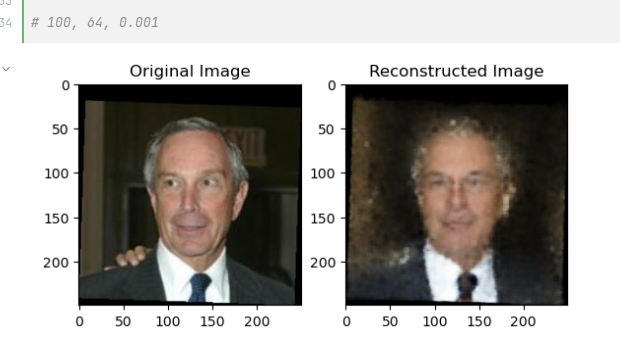

No.of Epochs - 10
Latent Space - 64
Learning rate - 0.001
Final Activation function - tanh

    Epoch [1/10], Loss: 3440.1398371452296
    Epoch [2/10], Loss: 1816.0432152494716
    Epoch [3/10], Loss: 1549.158836180461
    Epoch [4/10], Loss: 1423.7332321388135
    Epoch [5/10], Loss: 1355.0174492730034
    Epoch [6/10], Loss: 1297.6996073699804
    Epoch [7/10], Loss: 1261.131487712768
    Epoch [8/10], Loss: 1225.6541010907306
    Epoch [9/10], Loss: 1195.248089629095
    Epoch [10/10], Loss: 1162.1574356152817

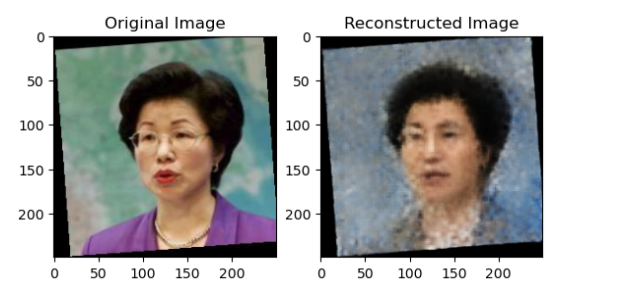


No.of Epochs - 10
Latent Space - 128
Learning rate - 0.001
Activation function - tanh

    Epoch [1/10], Loss: 3235.7527106096204
    Epoch [2/10], Loss: 1794.6669721373037
    Epoch [3/10], Loss: 1541.5115642455464
    Epoch [4/10], Loss: 1427.0306941967656
    Epoch [5/10], Loss: 1355.5776644351977
    Epoch [6/10], Loss: 1306.3592544039666
    Epoch [7/10], Loss: 1261.1342413713392
    Epoch [8/10], Loss: 1228.9681240210787
    Epoch [9/10], Loss: 1193.636694866678
    Epoch [10/10], Loss: 1158.1879772241564

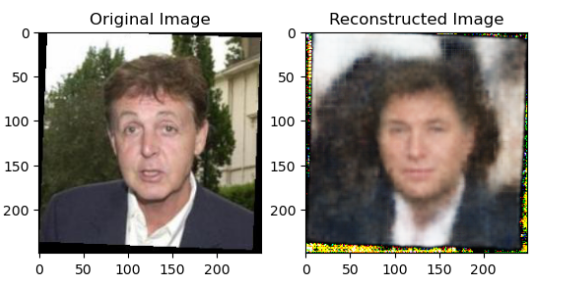



In [11]:
No.of Epochs - 15
Latent Space - 50
Learning rate - 0.1
Activation function - tanh

Epoch [1/15], Loss: nan
Epoch [2/15], Loss: nan
Epoch [3/15], Loss: nan
Epoch [4/15], Loss: nan
Epoch [5/15], Loss: nan
Epoch [6/15], Loss: nan
Epoch [7/15], Loss: nan
Epoch [8/15], Loss: nan
Epoch [9/15], Loss: nan
Epoch [10/15], Loss: nan
Epoch [11/15], Loss: nan
Epoch [12/15], Loss: nan
Epoch [12/15], Loss: nan
Epoch [14/15], Loss: nan
Epoch [15/15], Loss: nan

SyntaxError: invalid syntax (2440578931.py, line 1)

In [ ]:
num_epochs = 15
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0

    # Training loop
    for inputs, _ in dataloader:
        inputs = inputs.to(device)  # Move data to GPU
        optim.zero_grad()  # Zero the gradients
        outputs, mu_f, logvar_f = model(inputs)  # Forward pass

        #KL divergence
        kl = -0.5 * (1 + logvar_f - mu_f.pow(2) - logvar_f.exp())
        kl_loss = kl.sum() / inputs.size(0)
        fit = 0.5 * (outputs - inputs).pow(2)
        fit_loss = fit.sum() / inputs.size(0)
        loss = kl_loss + fit_loss
        loss.backward()  # Backward pass

        optim.step()  # Update weights

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(dataloader)

    # Print loss for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss}")



In [ ]:
**If your loss is not decreasing what do you have to do to troubleshoot it ?**

Latent Space Regularization: 
Check the weight assigned to the KL divergence term in your loss function. If it is too high, making the latent space too restrictive experiment with the weight to strike a balance between reconstruction quality and latent space quality.

Prior Distribution: 
    Analyze the selected prior distribution for the latent space. Is that suited to the data? If sparsity is needed, look to alternative priors such as a Laplace distribution.
Collapsed Latent Space: 
    Keep the latent space from collapsing; all samples would map to a single point. It can result from improper regularization or insufficient latent space dimensionality. Either expand the size of the latent space or vary the weight for KL divergence.
Early Decay of KL Divergence: 
    The KL divergence term could decrease faster than the reconstruction loss, giving rise to poor latent representations. Learning early on An idea is to anneal the weight of the KL divergence term over time.
Data Diversity: 
    VAEs are not working well on diverse datasets. Capture the full range of data You can use domain-specific architectures or latent space exploration techniques.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Fa

model.eval()  # Set model to evaluation mode

# Get a random image from the dataset
sample_image, _ = next(iter(dataloader))
sample_image = sample_image.to(device)
original_image = sample_image[0]  # Take the first image from the batch
original_image = original_image.to(device)

# Pass the image through the VAE
with torch.no_grad():
    reconstructed_image, _, _ = model(original_image.unsqueeze(0))  # Add batch dimension

# Convert tensors to numpy arrays for plotting
original_image_np = Fa.to_pil_image(original_image.cpu())
reconstructed_image_np = Fa.to_pil_image(reconstructed_image.squeeze(0).cpu())

# Plot the original and reconstructed images side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_np)
plt.title("Reconstructed Image")

plt.show()



In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Fa

# Assuming dataloader is your DataLoader and model is an instance of YourModel class
# model.eval()  # Set the model to evaluation mode

# Get a random image from the dataset
i = 0
while i < 10:
    sample_image, _ = next(iter(dataloader))
    sample_image = sample_image.to(device)
    original_image = sample_image[0]
    original_image = original_image.to(device)

    # Pass the image through the VAE
    with torch.no_grad():
        reconstructed_image, _, _ = model(original_image.unsqueeze(0))

    # Convert tensors to numpy arrays for plotting
    original_image_np = Fa.to_pil_image(original_image.cpu())
    reconstructed_image_np = Fa.to_pil_image(reconstructed_image.squeeze(0).cpu())

    # Plot the original and reconstructed images side by side
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image_np)
    plt.title("Reconstructed Image")

    plt.show()
    i += 1
